In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.


In [2]:
import glob
import logging
import pathlib
import pickle
import wget
import zipfile

import numpy as np
import pandas as pd
import scipy.io
from scipy import signal
from scipy.fft import fftshift

from algo_ecg.data import _make_path
import algo_ecg.data
import algo_ecg.preprocessing

import os

import matplotlib.pyplot as plt

from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

from PIL import Image
from IPython.display import display

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['figure.figsize'] = [12, 8]

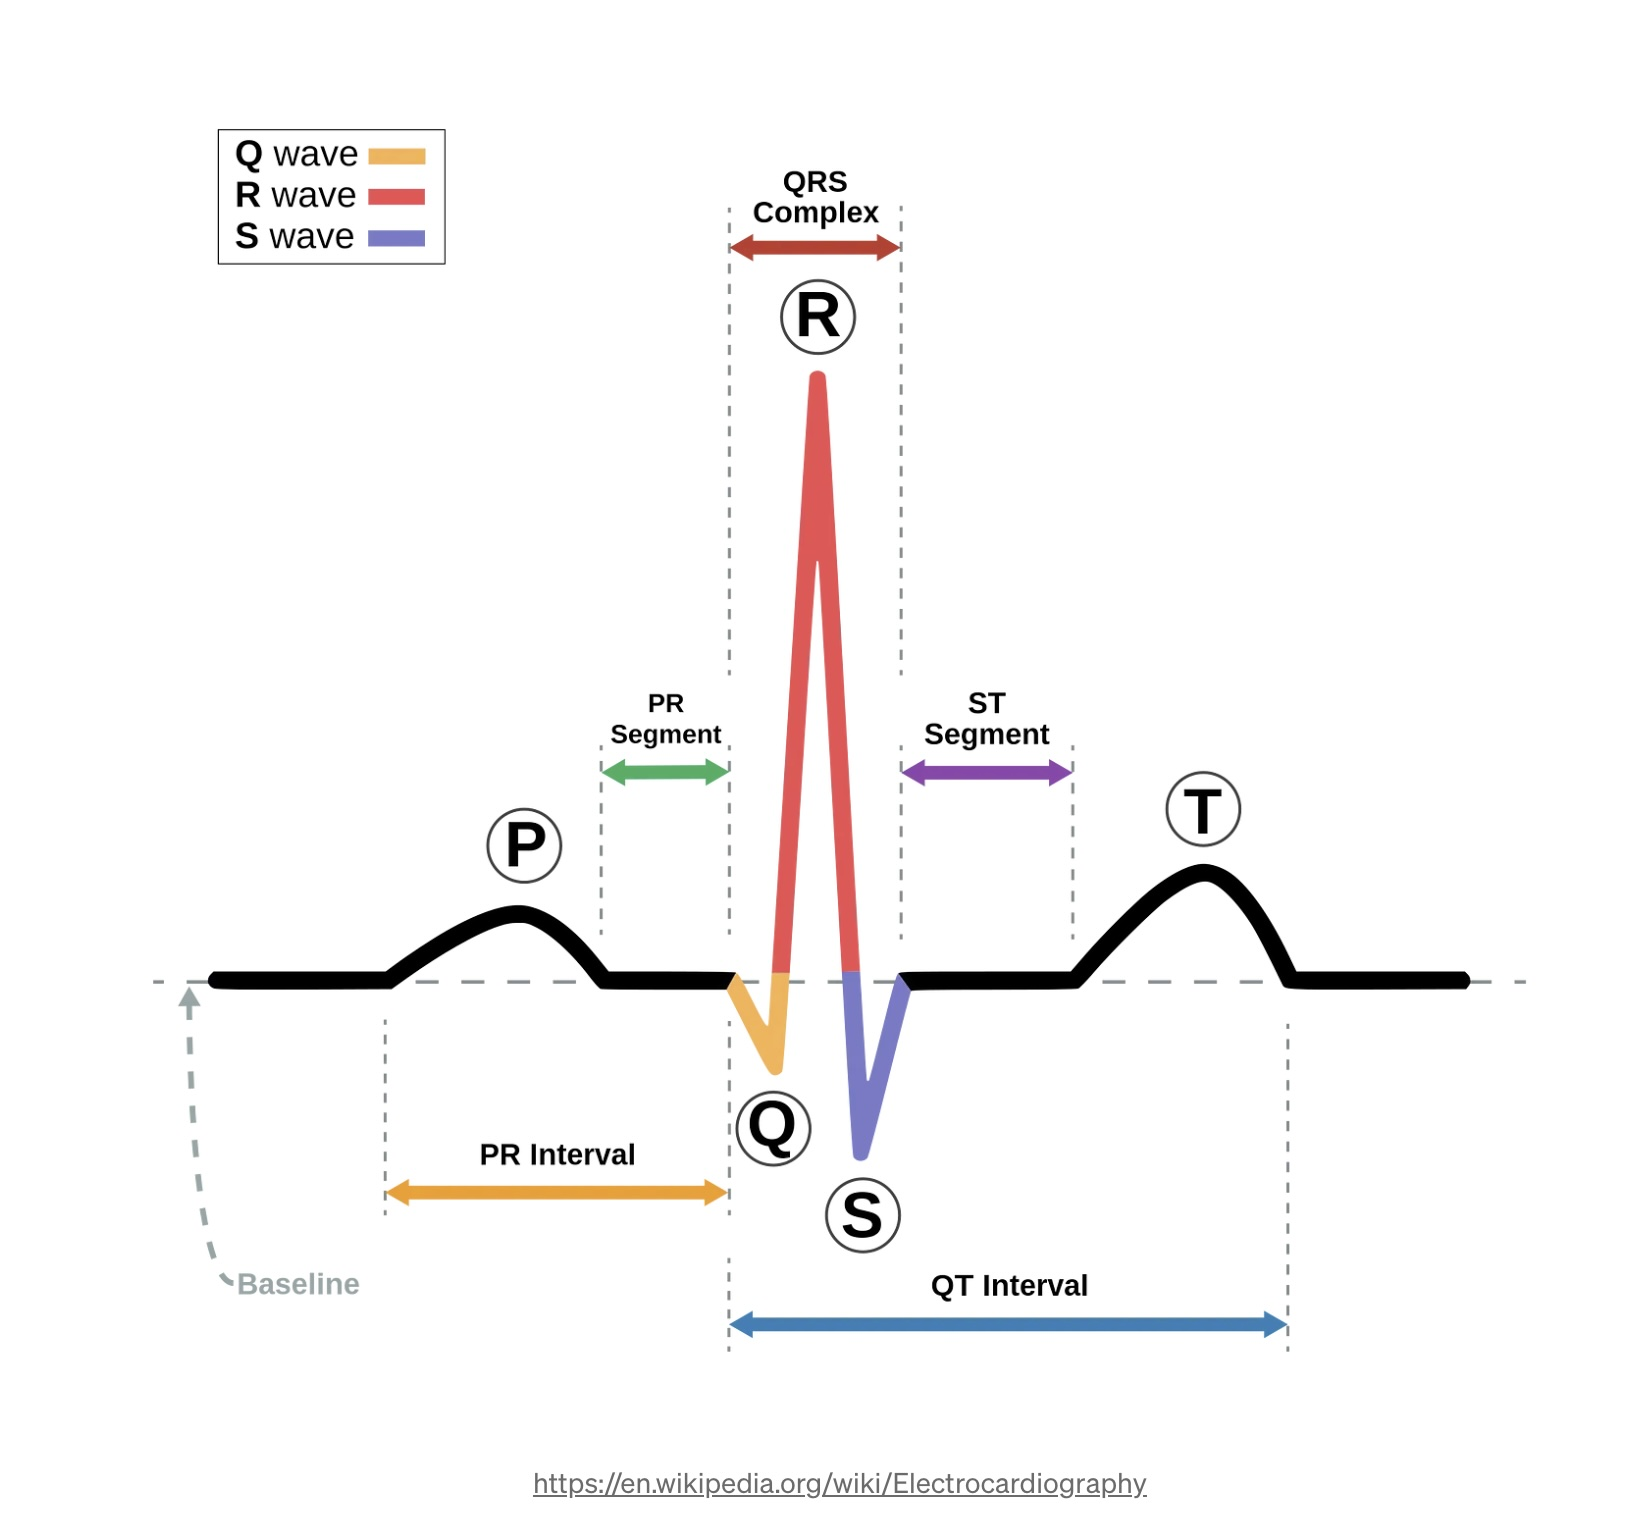

In [4]:
img = Image.open('../images/QRS.jpg')
display(img)

#### Concepts 
- Electrocardiogram: records electrical activity of the heart over a period of time using electrodes placed on the skin (traditionally). The heart generates electrical impulses as it contracts and relaxes which  cause the heart muscle to pump blood which can be detected by the electrodes on the skin that arise from the heart muscle's depolarization and repolarization during each heartbeat.
- P wave: atrial depolarization
- QRS complex: ventricular depolarization
- T wave : ventricular repolarization 


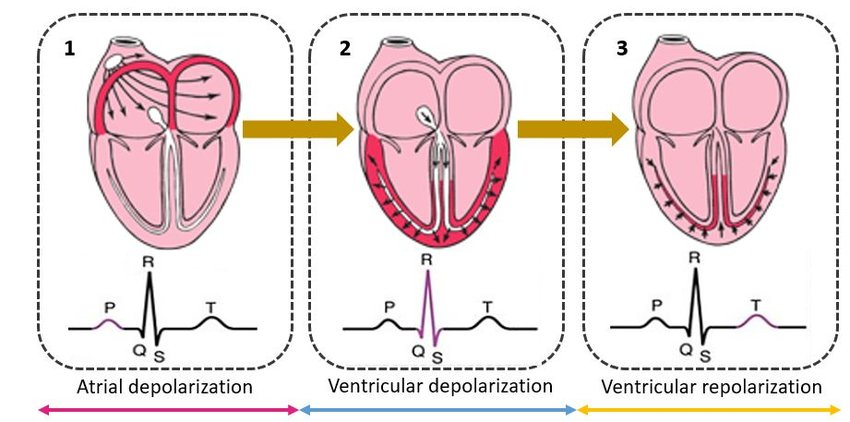

In [5]:
img = Image.open('../images/Successive-Stages-of-Depolarization-repolarization-of-the-Heart-Resulting-Different-Waves.png')
display(img)
#https://www.researchgate.net/publication/356826618_Hardware_Architecture_for_Adaptive_Dual_Threshold_Filter_and_Discrete_Wavelet_Transform_based_ECG_Signal_Denoising

### Atrial fibrillation 

Atrial fibrillation (AF) is a common cardiac arrhythmia characterized by irregular and often rapid heartbeats. In the context of the PQRST waves in an electrocardiogram (ECG), the features associated with atrial fibrillation can be described as follows:

- P-Wave: In a normal sinus rhythm, the P-wave represents atrial depolarization, indicating the contraction of the atria. In atrial fibrillation, there is typically no distinct and consistent P-wave observed. Instead, rapid, chaotic electrical activity in the atria leads to a fibrillatory or "quivering" pattern, and individual P-waves are often indistinguishable.
- QRS Complex:The QRS complex represents ventricular depolarization, indicating the contraction of the ventricles. In atrial fibrillation, the irregular and chaotic atrial activity doesn't necessarily affect the QRS complex directly. The QRS complex remains relatively normal unless there are additional conduction abnormalities or underlying heart conditions.
- T-Wave:The T-wave represents ventricular repolarization, indicating the recovery of the ventricles. In atrial fibrillation, the irregular atrial activity does not directly impact the T-wave. The T-wave typically appears normal unless there are other cardiac abnormalities present.
- Rhythm: One of the defining features of atrial fibrillation on an ECG is the absence of a regular rhythm. Instead of a consistent pattern of PQRST waves, there is irregular and often rapid ventricular response due to the chaotic atrial activity.

In summary, the key ECG characteristic of atrial fibrillation is the absence of a discernible and consistent P-wave. Instead, there is chaotic, rapid, and irregular electrical activity in the atria, leading to an irregular ventricular response. This irregularity is evident in the absence of a clear and organized atrial depolarization pattern, and the resulting ECG may show an irregularly irregular rhythm in the absence of a distinct PQRST pattern. It's important to note that atrial fibrillation can have varying presentations, and additional ECG features and clinical considerations are taken into account for diagnosis and management.

In [6]:
data_dir = "../data"
#data_dir = "/Users/jessie/data/PhysioNet_CinC"
features_dir = "training2017"
labels_csv_file='REFERENCE-v3.csv' 

In [7]:
labels_index = {
    'N': 0,  # normal
    'A': 1,  # afib
}


In [8]:
data_dir_path = _make_path(data_dir)
#labels_file = data_dir_path / labels_csv_file
labels_file = os.path.join(data_dir, labels_csv_file)
labels_df = pd.read_csv(labels_file, header=None)
labels = labels_df.iloc[:, 1]
labels.index = labels_df.iloc[:, 0]
features_glob_pattern = str(data_dir_path / features_dir / '*.mat')
files = sorted(glob.glob(features_glob_pattern))


In [9]:
labels
Counter(labels)

Counter({'N': 5076, 'A': 758, 'O': 2415, '~': 279})

In [10]:
labels_file

'../data/REFERENCE-v3.csv'

In [11]:
len(files)

8528

In [12]:
labels_df

,0,1
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A
...,...,...
8523,A08524,N
8524,A08525,O
8525,A08526,N
8526,A08527,N


In [13]:
f = files[3]
pid = pathlib.Path(f).stem
label = labels[pid]
int_label = labels_index[label]


In [14]:
f

'/Users/jessie/github/algo_ecg/notebooks/../data/training2017/A00004.mat'

In [15]:
pid

'A00004'

In [16]:
label

'A'

In [17]:
x_in = scipy.io.loadmat(f)['val'][0]

In [18]:
x_in

array([519, 619, 723, ..., 116,  17,  18], dtype=int16)

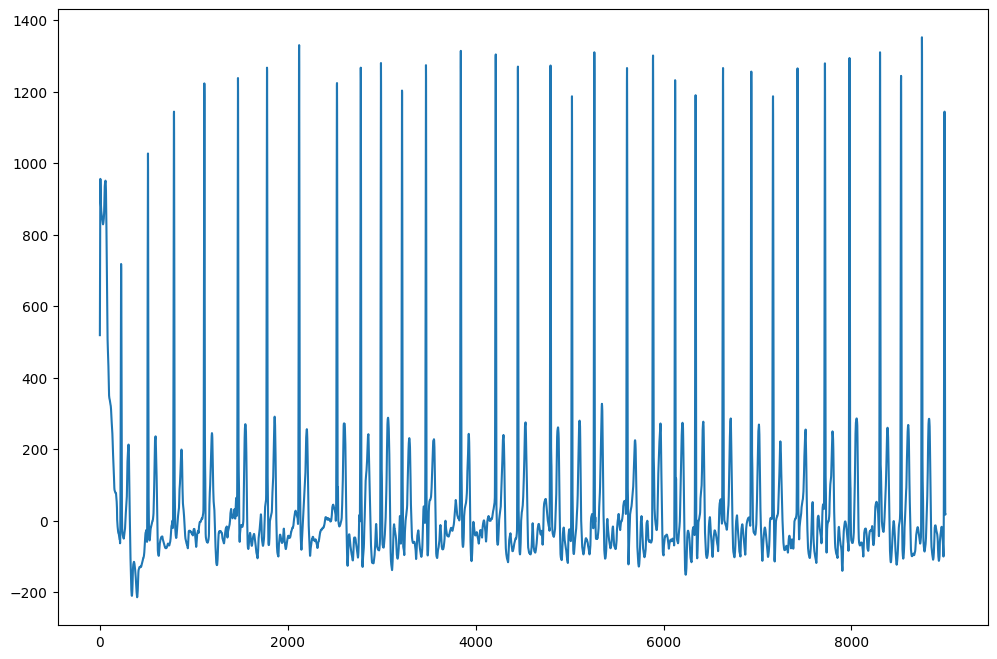

In [19]:
plt.plot(x_in)

### Band pass filter for ECG
A bandpass filter for ECG (Electrocardiogram) data is a filter designed to selectively pass a specific range of frequencies relevant to the ECG signal while attenuating frequencies outside that range. The goal is to isolate and enhance the components of the ECG signal within the desired frequency band. ECG signals typically have significant information in the low-frequency (0.5 Hz to 50 Hz) range, representing the heart's electrical activity.

A spectrogram is a visual representation of the frequency content of a signal as it varies with time. It is a way to analyze the spectrum of a time-varying signal, showing how the signal's frequency components change over the duration of the signal. Spectrograms are commonly used in various fields, including audio processing, communication systems, and biomedical signal analysis, such as the analysis of electrocardiogram (ECG) signals.

The spectrogram is generated by performing a Fourier Transform on short, overlapping segments of the signal and then plotting the resulting spectrum for each segment. The x-axis represents time, the y-axis represents frequency, and the color represents the magnitude of the corresponding frequency component. Darker colors usually represent lower magnitudes, and brighter colors represent higher magnitudes.

Here are the key components of a spectrogram:
- Time Axis (x-axis): The horizontal axis represents time, usually in seconds. Each column in the spectrogram corresponds to a specific time segment of the signal.
- Frequency Axis (y-axis): The vertical axis represents frequency, usually in hertz (Hz). Each row in the spectrogram corresponds to a specific frequency band.
- Color Intensity: The color at a specific time and frequency indicates the magnitude of the signal's power at that frequency. Brighter colors indicate higher power, while darker colors indicate lower power.

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x156a502e0>


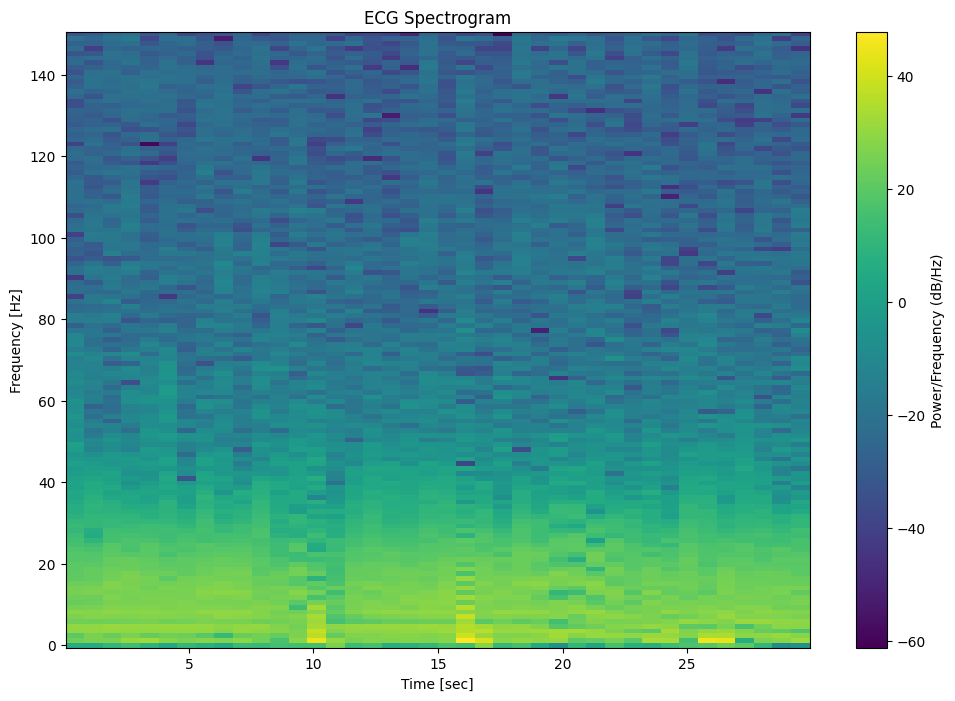

In [60]:
f, t, Sxx = signal.spectrogram(x_in, 300)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('ECG Spectrogram')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

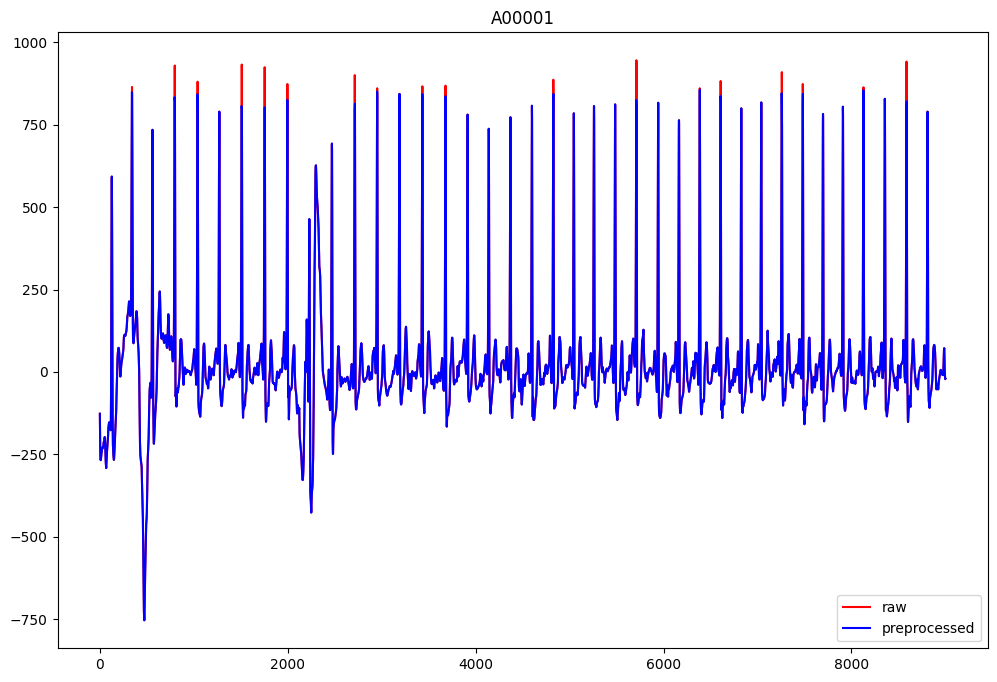

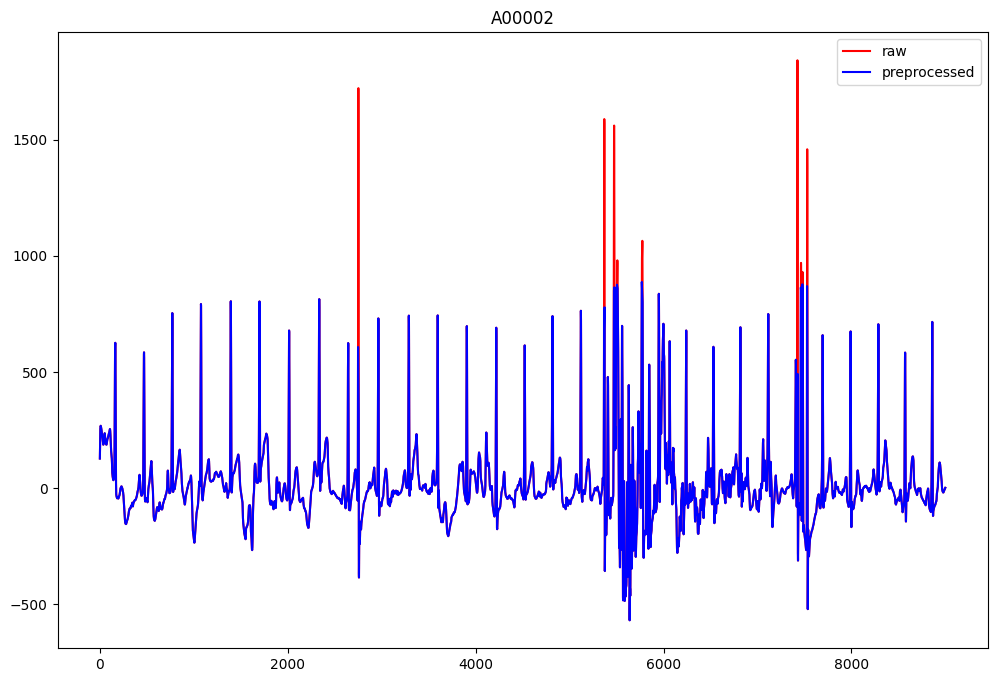

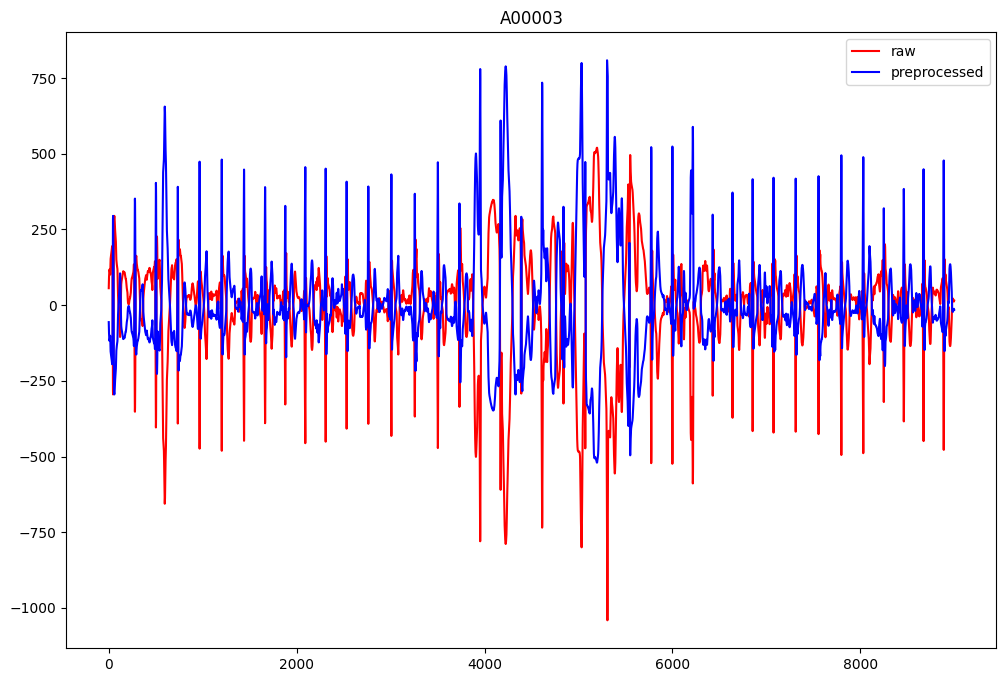

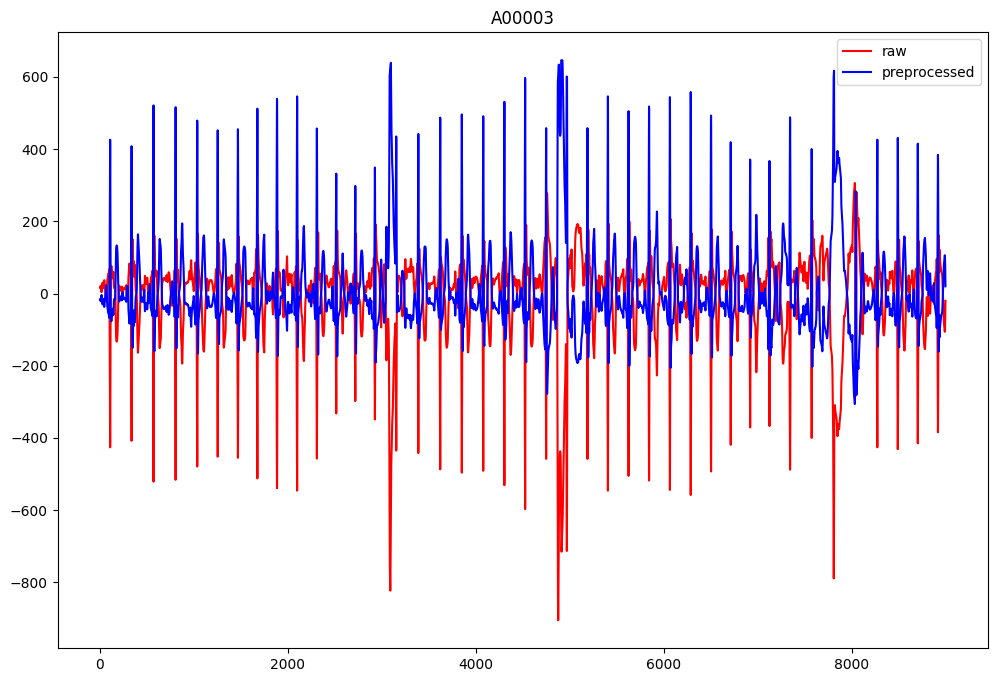

In [55]:
n_samples = 4
for x_in, x, pid in zip(X_in[:n_samples], X[:n_samples], pids):
    plt.plot(x_in, 'r', label='raw')
    plt.plot(x, 'b', label='preprocessed')
    plt.title(pid)
    plt.legend(loc='best')
    plt.show()

In [20]:
meta_dict = {'Normal rhythm': 'A00001', 
             'Atrial fibrillation': 'A00004', 
             'Other': 'A00077', 
             'Noisy recording': 'A01246'}

In [21]:
fig = make_subplots(
rows=4, cols=1, shared_xaxes=True, 
vertical_spacing=0.02)


for i, (k, v) in enumerate(meta_dict.items()):
    f_n = str(data_dir_path / features_dir / '{}.mat'.format(v))
    x_in = scipy.io.loadmat(f_n)['val'][0]
    data={'x': range(0, 9000), 'y': x_in}
    df = pd.DataFrame(data)
    df['x_s'] = df['x'].apply(lambda x: x/300)

    fig.add_trace(go.Scatter(x=df['x_s'], y=df['y'], name = k+ " " +v),
              row=i+1, col=1)
    fig['layout']['yaxis{}'.format(i+1)]['title']='Amplitude (mV)'
        
fig.update_layout(title_text="ECG")

fig['layout']['xaxis4']['title']='time(s)'

plotly.offline.plot(go.Figure(data=fig),
                    filename="temp.html", auto_open=True)

'temp.html'

In [22]:
X_in, y, pids = algo_ecg.data.import_physionet_data('../data', num_files_to_read=1000)

In [23]:
len(X_in)
len(pids)

690

In [24]:
#X = algo_ecg.preprocessing.preprocess(X_in)
X, pids = algo_ecg.preprocessing.preprocess_pid(X_in, pids)

DEBUG:root:
DEBUG:root:i=0, pid=A00001: 37 outliers found
DEBUG:root:
DEBUG:root:i=1, pid=A00002: 48 outliers found
DEBUG:root:
DEBUG:root:i=2, pid=A00003: 6 outliers found
DEBUG:root:i=2, pid=A00003: flipped values
DEBUG:root:
DEBUG:root:i=3, pid=A00003: 45 outliers found
DEBUG:root:i=3, pid=A00003: flipped values
DEBUG:root:
DEBUG:root:i=4, pid=A00004: 99 outliers found
DEBUG:root:
DEBUG:root:i=5, pid=A00005: 18 outliers found
DEBUG:root:
DEBUG:root:i=6, pid=A00005: 44 outliers found
DEBUG:root:
DEBUG:root:i=7, pid=A00006: 28 outliers found
DEBUG:root:
DEBUG:root:i=8, pid=A00007: 53 outliers found
DEBUG:root:i=8, pid=A00007: flipped values
DEBUG:root:
DEBUG:root:i=9, pid=A00009: 19 outliers found
DEBUG:root:
DEBUG:root:i=10, pid=A00010: 39 outliers found
DEBUG:root:
DEBUG:root:i=11, pid=A00010: 119 outliers found
DEBUG:root:
DEBUG:root:i=13, pid=A00012: 101 outliers found
DEBUG:root:
DEBUG:root:i=14, pid=A00016: 92 outliers found
DEBUG:root:i=14, pid=A00016: flipped values
DEBUG:root

In [25]:
x_outlier = X[4]
x_outlier_pid_name = pids[4]

In [26]:
x_outlier

array([519., 619., 723., ..., 116.,  17.,  18.])

In [53]:
def plot_proc (X, X_in, pids, i): 

    trace = X[i]
    x_outlier_pid_name = pids[i]
    
    data={'x': range(0, 9000), 'y': X_in[i], 'y_proc': X[i]}
    df = pd.DataFrame(data)
    df['x_s'] = df['x'].apply(lambda x: x/300)
    df['outlier'], _ = algo_ecg.preprocessing.remove_outliers(df['y'])
#    df['flipped'], _ = algo_ecg.preprocessing.flip_values(df['outlier'])
        
    fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, 
    vertical_spacing=0.02)
    
    fig.add_trace(go.Scatter(x=df['x_s'], y=df['y'], name = 'raw'),
              row=1, col=1)

    fig.add_trace(go.Scatter(x=df['x_s'], y=df['y_proc'], name = 'processed'),
          row=1, col=1) 

    ## highlight outliers 
    df_select_outlier = df.iloc[np.where(df['outlier'] != df['y'])]
    
    fig.add_trace(go.Scatter(x=df_select_outlier['x_s'], y=df_select_outlier['outlier'], name = 'outliers',
                             mode = 'markers', marker_symbol = 'star', marker_size = 15), 
                             row=1, col=1)
    
    fig['layout']['yaxis{}'.format(1)]['title']='Amplitude (mV)'
    
    fig.update_layout(title_text=x_outlier_pid_name)
    
    fig['layout']['xaxis1']['title']='time(s)'
    
    plotly.offline.plot(go.Figure(data=fig),
                        filename="{}.html".format(x_outlier_pid_name), auto_open=True)

In [54]:
plot_proc (X, X_in, pids, 3)

DEBUG:root:


In [42]:
plot_proc (X, X_in, pids, 71)

DEBUG:root:


In [56]:
n_samples = 10
for i in range(0, n_samples):
    plot_proc (X, X_in, pids, i)

DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
DEBUG:root:
